In [ ]:
!pip install albumentations  
!pip install segmentation-models-pytorch

In [2]:

import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
from albumentations import *
import time

from os import listdir
from os.path import isfile, join
import csv

In [ ]:
!cp /content/drive/MyDrive/mydata/celltrackingchallenge/nucleus_seg_data.zip /content/
!unzip /content/nucleus_seg_data.zip

In [4]:

features_path, label_path = "/content/features/", "/content/segmentation_maps/"

In [5]:
from PIL import Image
import os, sys

def resize(path):
  dirs = os.listdir( path )
  for item in tqdm(dirs):
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((256,256), Image.NEAREST)
      imResize.save(f+e, 'PNG', quality=100)

resize(label_path)
resize(features_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [6]:
ids=[]

label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
  ids.append(label_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')
df.head()

6790


,file_ids
0,59_12.png
1,37_34.png
2,13_8.png
3,33_21.png
4,169_29.png


In [7]:
class SegmentationDataset(Dataset):   
    def __init__(self, csv, augmentation =None, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        # image = cv2.imread("content/features/F"+self.ids[idx], 0)
        # mask = cv2.imread("content/segmentation_maps/L"+self.ids[idx], 0)

        image= np.array(Image.open("/content/features/F"+self.ids[idx]))
        mask=np.array(Image.open("/content/segmentation_maps/L"+self.ids[idx]))
        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        mask[mask != 0] = 1

        # border = dilate(canny(mask))
        # mask = mask - border
        mask = self.transform_label(mask)
        #mask = mask>1e-2
        mask = mask.float()
        return self.transform_image(image), mask
    
    def __len__(self):
        return len(self.ids)

In [8]:

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [9]:
full_dataset = SegmentationDataset(csv = "file_ids.csv",
                                    augmentation =  Compose([
                                                            GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            #RandomBrightnessContrast( p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    transforms.ToPILImage(),
                                                                    #transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                        
                                                                    transforms.ToPILImage(),
                                                                    #transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),

                                                                ]))

In [10]:
train_batch_size = 32
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

340 batches 
340  batches 


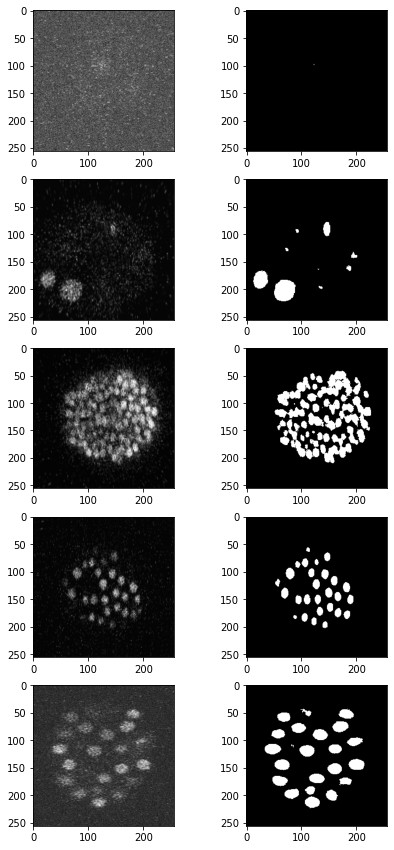

In [13]:
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))

for i in range(5):
    ax[i][0].imshow(images[i][0], cmap='gray')
    ax[i][1].imshow(masks[i][0], cmap='gray')

In [14]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["nucleus"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 1

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,#len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [15]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0015),
])

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=4, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)

max_score = 0
dice_losses = []
iou_scores  = []
times = []
lrs = []
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def plot_metrics(iou_scores, val_dice_losses, lrs):
    plt.rcParams['figure.figsize'] = 15, 4
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    clear_output(wait = True)
    ax1.plot(iou_scores, color='blue', label='train')
    
    ax1.grid()
    ax1.set_title('iou scores')
    ax2.plot(val_dice_losses, color = "green")
    ax2.grid()
    ax2.set_title('val dice loss')
    ax3.plot(lrs, color = "red")
    ax3.grid()
    ax3.set_title('learning rates')
    plt.show()

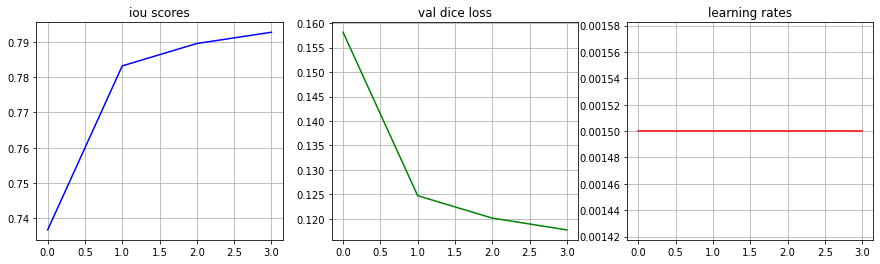

In [21]:
epochs = 2
plt.rcParams['figure.figsize'] = 15, 4
start_time = time.process_time()

for i in range(0, epochs):

    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)

    dice_losses.append(train_logs["dice_loss"]) 
    times.append(time.process_time() - start_time)
    iou_scores.append(train_logs["iou_score"])

    scheduler.step(1.)
    lrs.append(get_lr(optimizer))

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    clear_output(wait = True)
    plot_metrics(iou_scores, dice_losses, lrs)

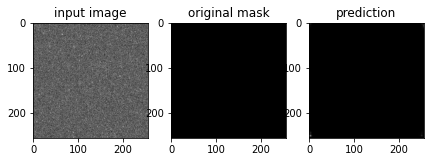

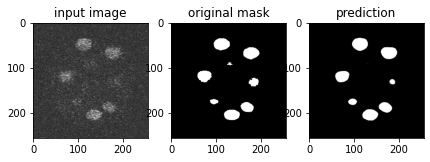

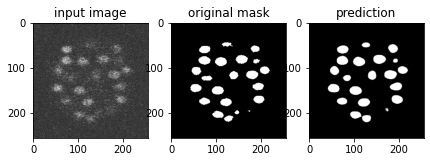

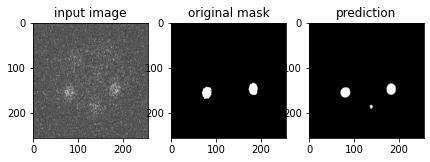

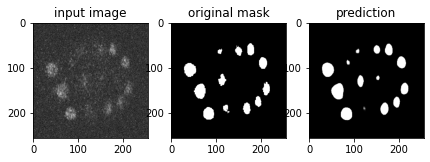

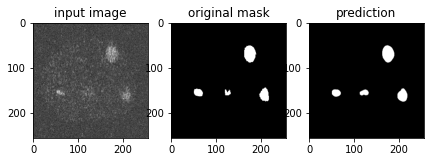

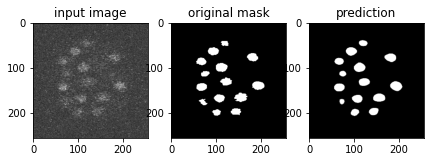

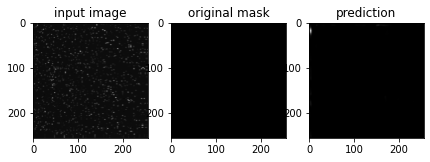

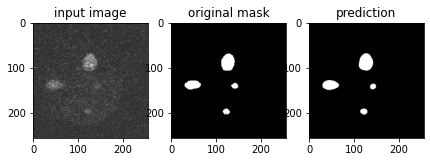

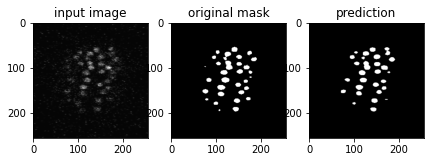

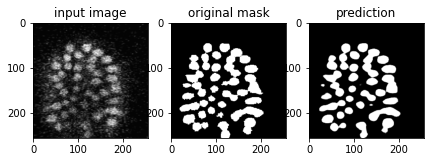

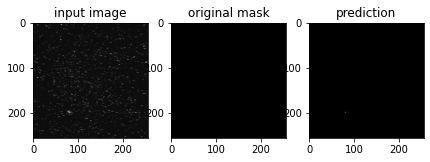

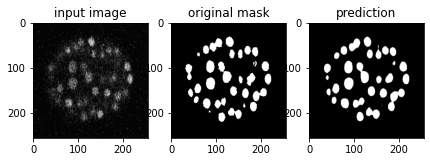

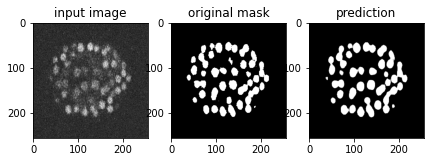

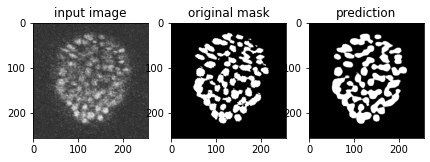

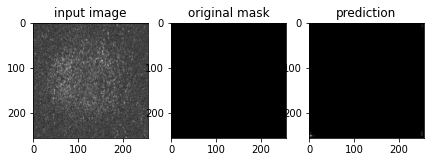

In [25]:
image, masks = next(iter(train_loader))
 
for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    # show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (7,14))
 
    ax.flat[0].imshow(show_img, cmap='gray')
    ax.flat[0].title.set_text('input image')
    
    ax.flat[1].imshow(show_mask, cmap='gray')
    ax.flat[1].title.set_text('original mask')
 
    ax.flat[2].imshow(show_pred, cmap='gray')
    ax.flat[2].title.set_text('prediction')
